## RFM analysis

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action="ignore")

plt.rc("font" , family="AppleGothic")

In [239]:
def nullcheck(dataframe):
    for i in dataframe.columns:
        na_sum = dataframe[i].isnull().sum()
        print(f'{i} 컬럼의 Null 갯수 :  {na_sum}')

In [328]:
df = pd.read_csv("./transaction.csv")
df["Date"] = df["Date"].apply(lambda x: pd.to_datetime(x))
df = df[(df["Date"] < "2019-12") & (df["Date"] >= "2019-01")]
df.dropna(how="any", inplace=True)

df["CustomerNo"] = df["CustomerNo"].apply(lambda x: str(int(x)))
df["Paid"] = df["Price"] * df["Quantity"]
df["yyyy"] = df["Date"].apply(lambda x: x.year)
df["mm"] = df["Date"].apply(lambda x: x.month)

In [335]:
df = df.reset_index().drop("index", axis=1)

In [336]:
df.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Paid,yyyy,mm
0,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432,United Kingdom,48.32,2019,11
1,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432,United Kingdom,24.16,2019,11
2,579522,2019-11-30,82483,Wood 2 Drawer Cabinet White Finish,6.04,8,14432,United Kingdom,48.32,2019,11
3,579522,2019-11-30,23493,Vintage Doily Travel Sewing Kit,6.04,10,14432,United Kingdom,60.40,2019,11
4,579522,2019-11-30,23240,Set Of 4 Knick Knack Tins Doily,6.19,6,14432,United Kingdom,37.14,2019,11


In [343]:
df["ProductNo"].nunique()

3686

In [318]:
df["Date"].min(), df["Date"].max()

(Timestamp('2019-01-04 00:00:00'), Timestamp('2019-11-30 00:00:00'))

In [319]:
nullcheck(df)

TransactionNo 컬럼의 Null 갯수 :  0
Date 컬럼의 Null 갯수 :  0
ProductNo 컬럼의 Null 갯수 :  0
ProductName 컬럼의 Null 갯수 :  0
Price 컬럼의 Null 갯수 :  0
Quantity 컬럼의 Null 갯수 :  0
CustomerNo 컬럼의 Null 갯수 :  0
Country 컬럼의 Null 갯수 :  0
Paid 컬럼의 Null 갯수 :  0
yyyy 컬럼의 Null 갯수 :  0
mm 컬럼의 Null 갯수 :  0


In [243]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510936 entries, 25361 to 536349
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TransactionNo  510936 non-null  object        
 1   Date           510936 non-null  datetime64[ns]
 2   ProductNo      510936 non-null  object        
 3   ProductName    510936 non-null  object        
 4   Price          510936 non-null  float64       
 5   Quantity       510936 non-null  int64         
 6   CustomerNo     510936 non-null  object        
 7   Country        510936 non-null  object        
 8   Paid           510936 non-null  float64       
 9   yyyy           510936 non-null  int64         
 10  mm             510936 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 46.8+ MB


(510936, 11)

In [244]:
df.describe()

,Price,Quantity,Paid,yyyy,mm
count,510936.000000,510936.000000,510936.000000,510936.000000,510936.000000
mean,12.967836,9.966961,114.104964,2018.917620,7.338007
std,8.580970,153.431638,1726.957653,0.274943,3.449574
min,5.130000,-74215.000000,-840113.800000,2018.000000,1.000000
25%,11.120000,1.000000,16.660000,2019.000000,4.000000
50%,11.980000,3.000000,44.400000,2019.000000,8.000000
75%,14.090000,10.000000,122.500000,2019.000000,10.000000
max,660.620000,74215.000000,840113.800000,2019.000000,12.000000


### EDA

In [364]:
idx_canceled = df[df["TransactionNo"].apply(lambda x: x[0] == "C")].index
print(len(idx_canceled))

7510


In [365]:
cancel = df[(df["CustomerNo"] == df["CustomerNo"]) & (df["ProductNo"] == df["ProductNo"]) & (df["Price"] == df["Price"]) & (df["Paid"] == df["Paid"])]

<AxesSubplot:xlabel='yyyy,mm'>

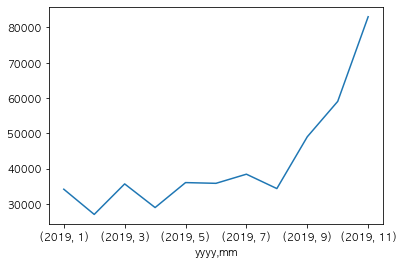

In [366]:
# Amount of transactions by month
pure_tran = df.drop(idx_canceled)
pure_tran.groupby(["yyyy", "mm"])["TransactionNo"].size().plot()

<AxesSubplot:xlabel='yyyy,mm'>

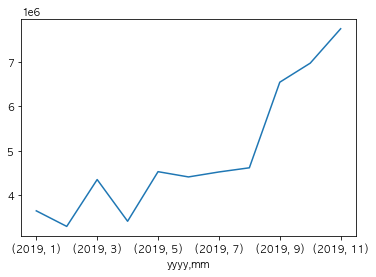

In [341]:
df.groupby(["yyyy", "mm"])["Paid"].sum().plot()

<AxesSubplot:ylabel='Density'>

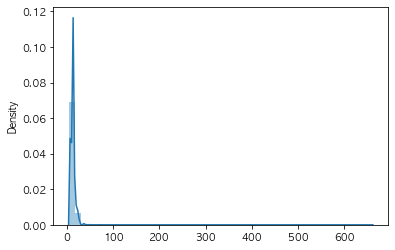

In [342]:
sns.distplot(df["Price"].values)

In [346]:
# 사분위수를 활용해 4개의 단계로 점수를 치환 나누는 함수(0.25, 0.5, 0.75, 1)
def scoring(values : pd.Series):
    score = []
    for i in values:
        for n in np.arange(0.25, 1.25, 0.25):
            if i <= values.quantile(n):
                score.append(n)
                break
    return score
        
# Recency, Frequency, Monetary 3개의 지표를 만들고 데이터프레임 형태로 반환하는 함수
def get_rfm_df(df:pd.DataFrame):
    # Recency
    recency_df = df.groupby('CustomerNo')['Date'].max().reset_index() 
    recency_df = recency_df.rename(columns={'Date':'Recency'})

    # Frequency
    frequency_df = df.groupby('CustomerNo')[['TransactionNo']].count() 
    frequency_df = frequency_df.rename(columns={'TransactionNo':'Frequency'}).reset_index()

    # Monetary
    monetary_df = pure_tran.groupby('CustomerNo')[['Paid']].sum()
    monetary_df = monetary_df.rename(columns={'Paid':'Monetary'}).reset_index() 
    
    # rfm_df
    rfm_df = pd.merge(recency_df, frequency_df, how='left', on='CustomerNo')
    rfm_df = pd.merge(rfm_df, monetary_df, how='left', on='CustomerNo')

    # Recency 수치화
    std_day = pd.to_datetime('2018-11-30') # 기준일자 설정
    time_diff = rfm_df['Recency'] - std_day 
    rfm_df['Recency'] = time_diff.dt.days

    # Scoreing 함수로 점수 구하기
    rfm_df['Recency'] = scoring(rfm_df['Recency'])
    rfm_df['Frequency'] = scoring(rfm_df['Frequency'])
    rfm_df['Monetary'] = scoring(rfm_df['Monetary'])
    rfm_df['Total_score'] = rfm_df['Recency'] + rfm_df['Frequency'] + rfm_df['Monetary']

    return rfm_df
    

In [350]:
rfm_df = get_rfm_df(pure_tran)

In [352]:
rfm_df

,CustomerNo,Recency,Frequency,Monetary,Total_score
0,12004,0.25,0.75,0.25,1.25
1,12006,0.25,0.25,0.25,0.75
2,12008,0.25,1.00,0.75,2.00
3,12024,0.25,0.25,0.25,0.75
4,12025,0.25,0.50,0.25,1.00
...,...,...,...,...,...
4514,18280,0.25,0.25,0.25,0.75
4515,18281,0.25,0.25,0.25,0.75
4516,18282,0.50,0.25,0.25,1.00
4517,18283,1.00,1.00,0.75,2.75


In [415]:
vip = rfm_df[(rfm_df["Recency"] >= 1)&(rfm_df["Frequency"] >= 1) & (rfm_df["Monetary"] >= 1)]
potential_vip = rfm_df[(rfm_df["Recency"] >= 0.75)&(rfm_df["Frequency"] <= 0.5) & (rfm_df["Monetary"] > 0.75)]
churn_vip = rfm_df[(rfm_df["Recency"] == 0.25)&(rfm_df["Frequency"] >= 0.75) & (rfm_df["Monetary"] >= 0.75)]

newbie = rfm_df[(rfm_df["Recency"] == 1)&(rfm_df["Frequency"] <= 0.25)]
high_monetary = rfm_df[rfm_df["Monetary"]== 1]

In [419]:
vip_df = pure_tran[pure_tran["CustomerNo"].apply(lambda x: x in vip["CustomerNo"].values)]
potential_vip_df = pure_tran[pure_tran["CustomerNo"].apply(lambda x: x in potential_vip["CustomerNo"].values)]
churn_vip_df = pure_tran[pure_tran["CustomerNo"].apply(lambda x: x in churn_vip["CustomerNo"].values)]

In [420]:
vip_df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Paid,yyyy,mm
0,579522,2019-11-30,84879,Assorted Colour Bird Ornament,6.04,8,14432,United Kingdom,48.32,2019,11
1,579522,2019-11-30,82486,3 Drawer Antique White Wood Cabinet,6.04,4,14432,United Kingdom,24.16,2019,11
2,579522,2019-11-30,82483,Wood 2 Drawer Cabinet White Finish,6.04,8,14432,United Kingdom,48.32,2019,11
3,579522,2019-11-30,23493,Vintage Doily Travel Sewing Kit,6.04,10,14432,United Kingdom,60.40,2019,11
4,579522,2019-11-30,23240,Set Of 4 Knick Knack Tins Doily,6.19,6,14432,United Kingdom,37.14,2019,11
...,...,...,...,...,...,...,...,...,...,...,...
468825,540019,2019-01-04,22487,White Wood Garden Plant Ladder,20.45,1,12957,United Kingdom,20.45,2019,1
468826,540019,2019-01-04,21217,Red Retrospot Round Cake Tins,20.45,1,12957,United Kingdom,20.45,2019,1
468827,540019,2019-01-04,22180,Retrospot Lamp,20.45,2,12957,United Kingdom,40.90,2019,1
468828,540021,2019-01-04,22776,Sweetheart 3 Tier Cake Stand,20.45,1,17841,United Kingdom,20.45,2019,1


In [421]:
potential_vip_df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Paid,yyyy,mm
161,579534,2019-11-30,84978,Hanging Heart Jar T-Light Holder,6.19,36,13784,United Kingdom,222.84,2019,11
6184,579498,2019-11-29,23084,Rabbit Night Light,7.67,2040,12798,Japan,15646.80,2019,11
7713,579006,2019-11-28,23084,Rabbit Night Light,7.24,72,17924,United Kingdom,521.28,2019,11
7714,579007,2019-11-28,23552,Bicycle Puncture Repair Kit,6.39,72,17924,United Kingdom,460.08,2019,11
7715,579007,2019-11-28,23498,Classic Bicycle Clips,7.24,24,17924,United Kingdom,173.76,2019,11
...,...,...,...,...,...,...,...,...,...,...,...
461146,540685,2019-01-10,85038,6 Chocolate Love Heart T-Lights,12.40,2,13685,United Kingdom,24.80,2019,1
461147,540685,2019-01-10,22973,Children's Circus Parade Mug,11.94,1,13685,United Kingdom,11.94,2019,1
465519,540370,2019-01-06,22791,T-Light Glass Fluted Antique,11.34,72,13094,United Kingdom,816.48,2019,1
466663,540175,2019-01-05,79321,Chilli Lights,14.33,480,16532,United Kingdom,6878.40,2019,1


In [422]:
churn_vip_df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Paid,yyyy,mm
251164,559862,2019-07-13,22405,Money Box Pocket Money Design,11.53,12,12782,Portugal,138.36,2019,7
251165,559862,2019-07-13,23014,Glass Apothecary Bottle Elixir,13.79,12,12782,Portugal,165.48,2019,7
251166,559862,2019-07-13,23012,Glass Apothecary Bottle Perfume,13.79,12,12782,Portugal,165.48,2019,7
251167,559862,2019-07-13,23306,Set Of 36 Pantry Paper Doilies,11.74,12,12782,Portugal,140.88,2019,7
251168,559862,2019-07-13,22355,Charlotte Bag Suki Design,11.12,10,12782,Portugal,111.20,2019,7
...,...,...,...,...,...,...,...,...,...,...,...
468807,540099,2019-01-04,22423,Regency Cakestand 3 Tier,23.32,4,15808,United Kingdom,93.28,2019,1
468810,540026,2019-01-04,22654,Deluxe Sewing Kit,22.42,1,12026,United Kingdom,22.42,2019,1
468811,540026,2019-01-04,22720,Set Of 3 Cake Tins Pantry Design,21.55,1,12026,United Kingdom,21.55,2019,1
468812,540026,2019-01-04,22945,Christmas Metal Tags Assorted,21.55,1,12026,United Kingdom,21.55,2019,1
